In [2]:
# sentiment_analysis_with_spacy_fixed.py

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from spektral.layers import GCNConv
import networkx as nx
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import random
import os
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils.class_weight import compute_class_weight
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# -------------------------------
# 0. Environment Setup
# -------------------------------

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

# Suppress TensorFlow warnings for cleaner output
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# -------------------------------
# 1. GPU Memory Management
# -------------------------------

# Enable memory growth to prevent TensorFlow from allocating all GPU memory at once
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Enabled memory growth for {len(gpus)} GPU(s).")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

# -------------------------------
# 2. Data Preparation
# -------------------------------

# Load the dataset
# Ensure the CSV has at least three columns: 'Text', 'Category', 'Polarity'
df = pd.read_csv(r"F:\Context-Resonance Transformer\Restaurant - Sheet1.csv")
df = df[['Text', 'Category', 'Polarity']]
print("Initial DataFrame:")
print(df.head())
print(f"Initial Data Shape: {df.shape}")

# Initialize Bengali stopwords and lemmatizer
# Note: WordNetLemmatizer is for English. For Bengali, consider using a Bengali-specific lemmatizer or skip lemmatization.
# For demonstration, proceed with lemmatization, but it may not work correctly for Bengali.
# Alternatively, use NLTK's SnowballStemmer for possible Bengali support.

# Download NLTK resources if not already
nltk.download('stopwords')
nltk.download('wordnet')

# Attempt to load Bengali stopwords; if not available, skip stopword removal
try:
    stop_words = set(stopwords.words('bengali'))
except LookupError:
    print("Bengali stopwords not found. Skipping stopword removal.")
    stop_words = set()

lemmatizer = WordNetLemmatizer()

# Function to clean text
def clean_text(text):
    # Keep only Bengali characters: Unicode range for Bengali: \u0980 - \u09FF
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces

    words = text.split()
    # Lemmatize and remove stopwords if available
    if stop_words:
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    else:
        words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words)

df['Text'] = df['Text'].apply(clean_text)
print("DataFrame after text cleaning:")
print(df.head())

# Upsampling 'Category' and 'Polarity' to balance classes
from sklearn.utils import resample

# Define a function to perform random upsampling
def upsample(df, target_column):
    # Get the maximum count of samples in any class
    max_count = df[target_column].value_counts().max()

    # Separate each class and upsample the minority classes
    upsampled_dfs = []
    for label in df[target_column].unique():
        # Get samples for the current label
        df_label = df[df[target_column] == label]

        # Upsample minority classes to match the majority class count
        df_upsampled = resample(
            df_label,
            replace=True,            # Sample with replacement
            n_samples=max_count,     # Match the number of samples in the majority class
            random_state=42          # Set random seed for reproducibility
        )
        upsampled_dfs.append(df_upsampled)

    # Combine the upsampled DataFrames
    return pd.concat(upsampled_dfs)

# Apply upsampling to 'Category' and 'Polarity'
df_upsampled_category = upsample(df, 'Category')
df_upsampled_polarity = upsample(df_upsampled_category, 'Polarity')

# Shuffle the DataFrame to mix the resampled classes
df_upsampled = df_upsampled_polarity.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class distribution
print("Category distribution after upsampling:")
print(df_upsampled['Category'].value_counts())
print("\nPolarity distribution after upsampling:")
print(df_upsampled['Polarity'].value_counts())

# Encode 'Category' and 'Polarity' labels
category_encoder = LabelEncoder()
polarity_encoder = LabelEncoder()

df_upsampled['Category_encoded'] = category_encoder.fit_transform(df_upsampled['Category'])
df_upsampled['Polarity_encoded'] = polarity_encoder.fit_transform(df_upsampled['Polarity'])

# Verify encoding
print("Encoded Category and Polarity:")
print(df_upsampled[['Category', 'Category_encoded', 'Polarity', 'Polarity_encoded']].head())

# Tokenize the text using a multilingual BERT tokenizer with padding and truncation
from transformers import BertTokenizer

# Use a multilingual BERT model that supports Bengali
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def window_based_adjacency(sentences, window_size=2, max_len=50):
    """
    Creates adjacency matrices based on a sliding window approach.
    Each token is connected to its neighbors within the window size.
    """
    adjacency_matrices = []
    
    for sentence in sentences:
        tokens = sentence.split()[:max_len]
        num_tokens = len(tokens)
        adj = np.zeros((max_len, max_len), dtype=np.float32)
        
        for i in range(num_tokens):
            for j in range(max(i - window_size, 0), min(i + window_size + 1, num_tokens)):
                if i != j:
                    adj[i, j] = 1.0
        
        adjacency_matrices.append(adj)
    
    return np.array(adjacency_matrices, dtype=np.float32)

def tokenize_sentences(sentences, tokenizer, max_len=20, batch_size=32):
    """
    Tokenizes sentences in batches for efficiency.
    """
    input_ids = []
    attention_masks = []
    
    for i in tqdm(range(0, len(sentences), batch_size), desc="Tokenizing"):
        batch = sentences[i:i+batch_size]
        encoded = tokenizer(
            list(batch),
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    # Concatenate all batches
    input_ids = tf.concat(input_ids, axis=0).numpy()
    attention_masks = tf.concat(attention_masks, axis=0).numpy()
    
    return input_ids, attention_masks

# Tokenize the data
input_ids, attention_masks = tokenize_sentences(df_upsampled['Text'].values, tokenizer, max_len=20, batch_size=32)

# Create window-based adjacency matrices
adjacency_matrices = window_based_adjacency(df_upsampled['Text'].values, window_size=2, max_len=20)

# Define labels for multi-task learning
labels_category = df_upsampled['Category_encoded'].values
labels_polarity = df_upsampled['Polarity_encoded'].values

# Split the data into training and testing sets
X_train_ids, X_test_ids, X_train_masks, X_test_masks, adjacency_train, adjacency_test, y_train_category, y_test_category, y_train_polarity, y_test_polarity = train_test_split(
    input_ids, attention_masks, adjacency_matrices, labels_category, labels_polarity, test_size=0.2, random_state=42, stratify=labels_category
)

print(f"Training samples: {X_train_ids.shape[0]}")
print(f"Testing samples: {X_test_ids.shape[0]}")

# -------------------------------
# 3. Model Architecture with GNN and Resonance Score Visualization
# -------------------------------

from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from spektral.layers import GCNConv

# Define the GNN-Based ContextResonance Layer
class GNNContextResonance(tf.keras.layers.Layer):
    def __init__(self, hidden_size, **kwargs):
        super(GNNContextResonance, self).__init__(**kwargs)
        self.gcn1 = GCNConv(128, activation='relu')  # First GCN layer with 128 units
        self.gcn2 = GCNConv(hidden_size, activation='relu')  # Second GCN layer to match hidden_size
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid')  # Resonance scores
    
    def call(self, inputs, adjacency):
        """
        inputs: BERT embeddings (batch_size, seq_length, hidden_size)
        adjacency: Adjacency matrices (batch_size, seq_length, seq_length)
        """
        # Apply GCN layers
        x = self.gcn1([inputs, adjacency])  # (batch_size, seq_length, 128)
        x = self.gcn2([x, adjacency])      # (batch_size, seq_length, hidden_size)
        
        # Compute resonance scores
        resonance_scores = self.dense(x)    # (batch_size, seq_length, 1)
        resonance_scores = tf.nn.sigmoid(resonance_scores)  # Normalize between 0 and 1
        
        # Modulate inputs with resonance scores
        modulated_inputs = inputs * resonance_scores  # Element-wise multiplication
        
        return modulated_inputs, resonance_scores  # Return scores for visualization
    
    def get_config(self):
        base_config = super(GNNContextResonance, self).get_config()
        return base_config

# Define the complete model with GNNContextResonance and multi-task outputs
def build_model_with_gnn(bert_model, hidden_size, max_len=20):
    # Define Inputs
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='attention_masks')
    adjacency = Input(shape=(max_len, max_len), dtype=tf.float32, name='adjacency')
    
    # Get BERT embeddings
    bert_outputs = bert_model([input_ids, attention_masks])
    sequence_output = bert_outputs.last_hidden_state  # (batch_size, seq_length, hidden_size)
    
    # Apply GNN-Based ContextResonance
    gnn_resonance_layer = GNNContextResonance(hidden_size)
    transformer_output, resonance_scores = gnn_resonance_layer(sequence_output, adjacency)
    
    # Continue with Transformer Block (Multi-Head Attention + FFN)
    attention_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=12, key_dim=hidden_size // 12, name='multi_head_attention'
    )
    attention_output, attention_scores = attention_layer(
        query=transformer_output,
        value=transformer_output,
        key=transformer_output,
        return_attention_scores=True
    )  # Using already modulated embeddings
    
    # Add & Normalize
    attention_output = LayerNormalization(epsilon=1e-6)(transformer_output + attention_output)
    
    # Feed-Forward Network
    ffn_output = Dense(3072, activation='relu')(attention_output)
    ffn_output = Dense(hidden_size)(ffn_output)
    
    # Add & Normalize
    ffn_output = LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)
    
    # Pooling: Take the mean of the token embeddings
    pooled_output = GlobalAveragePooling1D()(ffn_output)
    
    # Classification Heads for Multi-Task
    dropout = Dropout(0.3)(pooled_output)
    
    # Category Output
    category_output = Dense(len(category_encoder.classes_), activation='softmax', name='category_output')(dropout)
    
    # Polarity Output
    polarity_output = Dense(len(polarity_encoder.classes_), activation='softmax', name='polarity_output')(dropout)
    
    # Define the Model
    model = Model(
        inputs=[input_ids, attention_masks, adjacency],
        outputs=[category_output, polarity_output, resonance_scores, attention_scores]  # Multi-task outputs
    )
    
    return model

# Load pre-trained multilingual BERT model
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')
hidden_size = bert_model.config.hidden_size  # Typically 768

# Build the model
model = build_model_with_gnn(bert_model, hidden_size, max_len=20)

# Summary of the model
model.summary()

Enabled memory growth for 1 GPU(s).
Initial DataFrame:
                                                Text                 Category  \
0              স্টাফ কিন্তু, আমাদের জন্য ভয়ঙ্কর ছিল।                  service   
1  শুধুমাত্র,রিডামিং ফ্যাক্টর খাদ্য ছিল,পুরোপুরি ...                     food   
2  শুধুমাত্র,রিডামিং ফ্যাক্টর খাদ্য ছিল,পুরোপুরি ...  anecdotes/miscellaneous   
3  খাবার একদমই ব্যতিক্রমী, একটি খুব সক্ষম রান্নাঘ...                     food   
4  যেখানে গাব্রিয়েলা লোকালি আপনাকে শুভেচ্ছা জানা...                  service   

   Polarity  
0  negative  
1  positive  
2  negative  
3  positive  
4  positive  
Initial Data Shape: (2059, 3)
DataFrame after text cleaning:
                                                Text                 Category  \
0                                       স্টাফ ভয়ঙ্কর                  service   
1  শুধুমাত্ররিডামিং ফ্যাক্টর খাদ্য ছিলপুরোপুরি ন্...                     food   
2  শুধুমাত্ররিডামিং ফ্যাক্টর খাদ্য ছিলপুরোপুরি ন্...  anecdotes/miscel

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Tokenizing: 100%|██████████| 258/258 [00:02<00:00, 121.10it/s]


Training samples: 6582
Testing samples: 1646


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 20)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  177853440   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 20,                                          

In [3]:
# -------------------------------
# 4. Defining the Custom Loss Function and Metrics
# -------------------------------

# Define the optimizer
optimizer = Adam(learning_rate=2e-5, epsilon=1e-08)

# Define the standard loss functions with 'none' reduction to get per-sample losses
loss_fn_category = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
loss_fn_polarity = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

# Define metrics
train_accuracy_category = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy_category')
train_accuracy_polarity = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy_polarity')
val_accuracy_category = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy_category')
val_accuracy_polarity = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy_polarity')

# Compute class weights based on the training labels for both tasks
class_weights_category = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_category),
    y=y_train_category
)

class_weights_polarity = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_polarity),
    y=y_train_polarity
)

# Convert class_weights to dictionaries for easy lookup
class_weights_dict_category = {i: weight for i, weight in enumerate(class_weights_category)}
class_weights_dict_polarity = {i: weight for i, weight in enumerate(class_weights_polarity)}
print("Category Class Weights:", class_weights_dict_category)
print("Polarity Class Weights:", class_weights_dict_polarity)


Category Class Weights: {0: 0.8531432274789371, 1: 0.7868499701135684, 2: 1.258508604206501, 3: 1.180627802690583, 4: 1.092448132780083}
Polarity Class Weights: {0: 1.0157407407407408, 1: 1.0009124087591241, 2: 0.9930597465298733, 3: 0.9906682721252258}


In [4]:
# -------------------------------
# 4. Defining the Custom Loss Function and Metrics
# -------------------------------
import time  # For tracking training time
import matplotlib.pyplot as plt
import seaborn as sns

# Define the optimizer
optimizer = Adam(learning_rate=2e-5, epsilon=1e-08)

# Define the standard loss functions with 'none' reduction to get per-sample losses
loss_fn_category = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
loss_fn_polarity = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

# Define metrics
train_accuracy_category = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy_category')
train_accuracy_polarity = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy_polarity')
val_accuracy_category = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy_category')
val_accuracy_polarity = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy_polarity')

# Compute class weights based on the training labels for both tasks
class_weights_category = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_category),
    y=y_train_category
)

class_weights_polarity = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_polarity),
    y=y_train_polarity
)

# Convert class_weights to dictionaries for easy lookup
class_weights_dict_category = {i: weight for i, weight in enumerate(class_weights_category)}
class_weights_dict_polarity = {i: weight for i, weight in enumerate(class_weights_polarity)}
print("Category Class Weights:", class_weights_dict_category)
print("Polarity Class Weights:", class_weights_dict_polarity)

@tf.function
def train_step(input_ids, attention_masks, adjacency, labels_category, labels_polarity):
    with tf.GradientTape() as tape:
        # Forward pass
        predictions_category, predictions_polarity, resonance_scores, _ = model([input_ids, attention_masks, adjacency], training=True)
        
        # Compute per-sample standard loss for category
        cce_loss_category = loss_fn_category(labels_category, predictions_category)  # Shape: (batch_size,)
        
        # Convert class_weights_dict to tensors with dtype float32
        class_weights_tensor_category = tf.gather(tf.constant(class_weights_category, dtype=tf.float32), labels_category)
        class_weights_tensor_polarity = tf.gather(tf.constant(class_weights_polarity, dtype=tf.float32), labels_polarity)
        
        # Apply class weights to the per-sample loss for category
        weighted_cce_loss_category = cce_loss_category * class_weights_tensor_category  # Shape: (batch_size,)
        weighted_cce_loss_category_mean = tf.reduce_mean(weighted_cce_loss_category)
        
        # Compute per-sample standard loss for polarity
        cce_loss_polarity = loss_fn_polarity(labels_polarity, predictions_polarity)  # Shape: (batch_size,)
        
        # Apply class weights to the per-sample loss for polarity
        weighted_cce_loss_polarity = cce_loss_polarity * class_weights_tensor_polarity  # Shape: (batch_size,)
        weighted_cce_loss_polarity_mean = tf.reduce_mean(weighted_cce_loss_polarity)
        
        # Compute smoothness loss
        resonance_scores = tf.squeeze(resonance_scores, axis=-1)  # (batch_size, seq_length)
        resonance_diff = resonance_scores[:, :, tf.newaxis] - resonance_scores[:, tf.newaxis, :]  # (batch_size, seq_length, seq_length)
        squared_diff = tf.square(resonance_diff)
        smoothness_loss = tf.reduce_sum(adjacency * squared_diff, axis=[1,2])  # (batch_size,)
        smoothness_loss = tf.reduce_mean(smoothness_loss)
        
        # Total loss with class weights
        alpha = 0.1
        total_loss = weighted_cce_loss_category_mean + weighted_cce_loss_polarity_mean + alpha * smoothness_loss
    
    # Compute gradients
    gradients = tape.gradient(total_loss, model.trainable_variables)
    
    # Update weights
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    # Update metrics
    train_accuracy_category.update_state(labels_category, predictions_category)
    train_accuracy_polarity.update_state(labels_polarity, predictions_polarity)
    
    return total_loss, weighted_cce_loss_category_mean, weighted_cce_loss_polarity_mean, smoothness_loss

@tf.function
def test_step(input_ids, attention_masks, adjacency, labels_category, labels_polarity):
    # Forward pass
    predictions_category, predictions_polarity, resonance_scores, _ = model([input_ids, attention_masks, adjacency], training=False)
    
    # Compute per-sample standard loss for category
    cce_loss_category = loss_fn_category(labels_category, predictions_category)  # Shape: (batch_size,)
    
    # Convert class_weights_dict to tensors with dtype float32
    class_weights_tensor_category = tf.gather(tf.constant(class_weights_category, dtype=tf.float32), labels_category)
    class_weights_tensor_polarity = tf.gather(tf.constant(class_weights_polarity, dtype=tf.float32), labels_polarity)
    
    # Apply class weights to the per-sample loss for category
    weighted_cce_loss_category = cce_loss_category * class_weights_tensor_category  # Shape: (batch_size,)
    weighted_cce_loss_category_mean = tf.reduce_mean(weighted_cce_loss_category)
    
    # Compute per-sample standard loss for polarity
    cce_loss_polarity = loss_fn_polarity(labels_polarity, predictions_polarity)  # Shape: (batch_size,)
    
    # Apply class weights to the per-sample loss for polarity
    weighted_cce_loss_polarity = cce_loss_polarity * class_weights_tensor_polarity  # Shape: (batch_size,)
    weighted_cce_loss_polarity_mean = tf.reduce_mean(weighted_cce_loss_polarity)
    
    # Compute smoothness loss
    resonance_scores = tf.squeeze(resonance_scores, axis=-1)  # (batch_size, seq_length)
    resonance_diff = resonance_scores[:, :, tf.newaxis] - resonance_scores[:, tf.newaxis, :]  # (batch_size, seq_length, seq_length)
    squared_diff = tf.square(resonance_diff)
    smoothness_loss = tf.reduce_sum(adjacency * squared_diff, axis=[1,2])  # (batch_size,)
    smoothness_loss = tf.reduce_mean(smoothness_loss)
    
    # Total loss with class weights
    alpha = 0.01
    total_loss = weighted_cce_loss_category_mean + weighted_cce_loss_polarity_mean + alpha * smoothness_loss
    
    # Update metrics
    val_accuracy_category.update_state(labels_category, predictions_category)
    val_accuracy_polarity.update_state(labels_polarity, predictions_polarity)
    
    return total_loss, weighted_cce_loss_category_mean, weighted_cce_loss_polarity_mean, smoothness_loss

# -------------------------------
# 5. Training the Model
# -------------------------------

# Define training parameters
epochs = 20
batch_size = 16
alpha = 0.01

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_train_ids,
        'attention_masks': X_train_masks,
        'adjacency': adjacency_train
    },
    y_train_category,
    y_train_polarity
)).shuffle(buffer_size=10000).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_test_ids,
        'attention_masks': X_test_masks,
        'adjacency': adjacency_test
    },
    y_test_category,
    y_test_polarity
)).batch(batch_size)

# Initialize history dictionaries
history = {
    'train_loss': [],
    'train_cce_loss_category': [],
    'train_cce_loss_polarity': [],
    'train_smoothness_loss': [],
    'train_accuracy_category': [],
    'train_accuracy_polarity': [],
    'val_loss': [],
    'val_cce_loss_category': [],
    'val_cce_loss_polarity': [],
    'val_smoothness_loss': [],
    'val_accuracy_category': [],
    'val_accuracy_polarity': []
}

# Initialize total training time
total_training_start_time = time.time()

# Initialize a list to store epoch durations
epoch_durations = []

# Training Loop
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch+1}")
    
    # Record the start time of the epoch
    epoch_start_time = time.time()
    
    # Reset metrics at the start of each epoch
    train_accuracy_category.reset_states()
    train_accuracy_polarity.reset_states()
    val_accuracy_category.reset_states()
    val_accuracy_polarity.reset_states()
    
    # Training
    total_loss_avg = tf.keras.metrics.Mean()
    cce_loss_category_avg = tf.keras.metrics.Mean()
    cce_loss_polarity_avg = tf.keras.metrics.Mean()
    smoothness_loss_avg = tf.keras.metrics.Mean()
    
    for step, (batch_inputs, batch_labels_category, batch_labels_polarity) in enumerate(train_dataset):
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        adjacency = batch_inputs['adjacency']
        labels_category = batch_labels_category
        labels_polarity = batch_labels_polarity
        
        total_loss, cce_loss_cat, cce_loss_pol, smoothness_loss = train_step(input_ids, attention_masks, adjacency, labels_category, labels_polarity)
        
        total_loss_avg.update_state(total_loss)
        cce_loss_category_avg.update_state(cce_loss_cat)
        cce_loss_polarity_avg.update_state(cce_loss_pol)
        smoothness_loss_avg.update_state(smoothness_loss)
        
        if step % 100 == 0:
            print(f"Step {step}: Total Loss = {total_loss_avg.result():.4f}, CCE Loss Category = {cce_loss_category_avg.result():.4f}, CCE Loss Polarity = {cce_loss_polarity_avg.result():.4f}, Smoothness Loss = {smoothness_loss_avg.result():.4f}, Train Accuracy Category = {train_accuracy_category.result():.4f}, Train Accuracy Polarity = {train_accuracy_polarity.result():.4f}")
    
    # Calculate epoch duration
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    epoch_durations.append(epoch_duration)
    
    # Record training metrics
    history['train_loss'].append(total_loss_avg.result().numpy())
    history['train_cce_loss_category'].append(cce_loss_category_avg.result().numpy())
    history['train_cce_loss_polarity'].append(cce_loss_polarity_avg.result().numpy())
    history['train_smoothness_loss'].append(smoothness_loss_avg.result().numpy())
    history['train_accuracy_category'].append(train_accuracy_category.result().numpy())
    history['train_accuracy_polarity'].append(train_accuracy_polarity.result().numpy())
    
    print(f"Epoch {epoch+1} Training Loss: {total_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training CCE Loss Category: {cce_loss_category_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training CCE Loss Polarity: {cce_loss_polarity_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training Smoothness Loss: {smoothness_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training Accuracy Category: {train_accuracy_category.result():.4f}")
    print(f"Epoch {epoch+1} Training Accuracy Polarity: {train_accuracy_polarity.result():.4f}")
    
    # Validation
    val_loss_avg = tf.keras.metrics.Mean()
    val_cce_loss_category_avg = tf.keras.metrics.Mean()
    val_cce_loss_polarity_avg = tf.keras.metrics.Mean()
    val_smoothness_loss_avg = tf.keras.metrics.Mean()
    
    for batch_inputs, batch_labels_category, batch_labels_polarity in test_dataset:
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        adjacency = batch_inputs['adjacency']
        labels_category = batch_labels_category
        labels_polarity = batch_labels_polarity
        
        total_loss, cce_loss_cat, cce_loss_pol, smoothness_loss = test_step(input_ids, attention_masks, adjacency, labels_category, labels_polarity)
        
        val_loss_avg.update_state(total_loss)
        val_cce_loss_category_avg.update_state(cce_loss_cat)
        val_cce_loss_polarity_avg.update_state(cce_loss_pol)
        val_smoothness_loss_avg.update_state(smoothness_loss)
    
    # Record validation metrics
    history['val_loss'].append(val_loss_avg.result().numpy())
    history['val_cce_loss_category'].append(val_cce_loss_category_avg.result().numpy())
    history['val_cce_loss_polarity'].append(val_cce_loss_polarity_avg.result().numpy())
    history['val_smoothness_loss'].append(val_smoothness_loss_avg.result().numpy())
    history['val_accuracy_category'].append(val_accuracy_category.result().numpy())
    history['val_accuracy_polarity'].append(val_accuracy_polarity.result().numpy())
    
    print(f"Epoch {epoch+1} Validation Loss: {val_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation CCE Loss Category: {val_cce_loss_category_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation CCE Loss Polarity: {val_cce_loss_polarity_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation Smoothness Loss: {val_smoothness_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation Accuracy Category: {val_accuracy_category.result():.4f}")
    print(f"Epoch {epoch+1} Validation Accuracy Polarity: {val_accuracy_polarity.result():.4f}")

# Calculate total training time
total_training_end_time = time.time()
total_training_duration = total_training_end_time - total_training_start_time

# Convert to hours, minutes, and seconds
hours, rem = divmod(total_training_duration, 3600)
minutes, seconds = divmod(rem, 60)
print(f"\nTotal Training Time: {int(hours)}h {int(minutes)}m {int(seconds)}s")


Category Class Weights: {0: 0.8531432274789371, 1: 0.7868499701135684, 2: 1.258508604206501, 3: 1.180627802690583, 4: 1.092448132780083}
Polarity Class Weights: {0: 1.0157407407407408, 1: 1.0009124087591241, 2: 0.9930597465298733, 3: 0.9906682721252258}

Start of epoch 1
Step 0: Total Loss = 3.9535, CCE Loss Category = 2.1388, CCE Loss Polarity = 1.8129, Smoothness Loss = 0.0183, Train Accuracy Category = 0.0625, Train Accuracy Polarity = 0.2500
Step 100: Total Loss = 3.0056, CCE Loss Category = 1.6099, CCE Loss Polarity = 1.3955, Smoothness Loss = 0.0029, Train Accuracy Category = 0.3540, Train Accuracy Polarity = 0.3824
Step 200: Total Loss = 2.5544, CCE Loss Category = 1.3504, CCE Loss Polarity = 1.2039, Smoothness Loss = 0.0016, Train Accuracy Category = 0.4754, Train Accuracy Polarity = 0.4767
Step 300: Total Loss = 2.2132, CCE Loss Category = 1.1656, CCE Loss Polarity = 1.0474, Smoothness Loss = 0.0011, Train Accuracy Category = 0.5613, Train Accuracy Polarity = 0.5540
Step 400: 

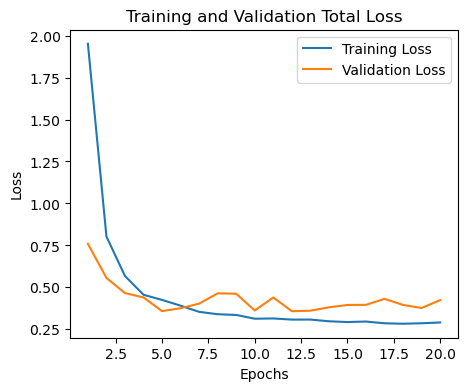

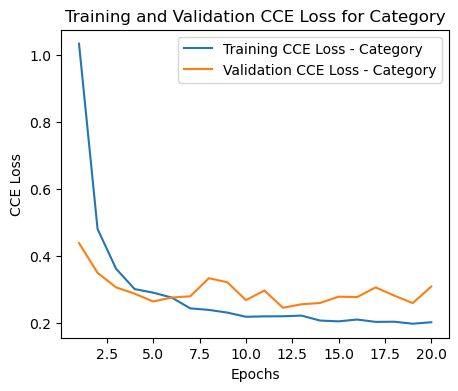

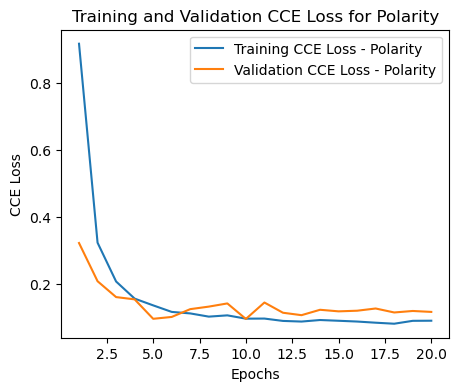

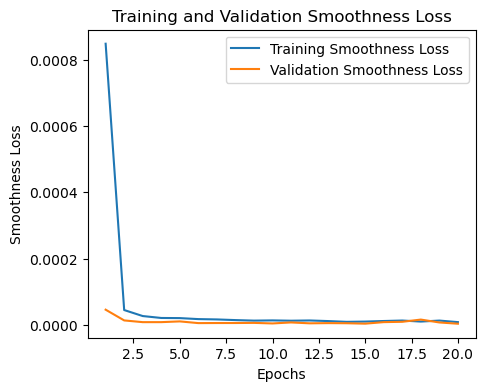

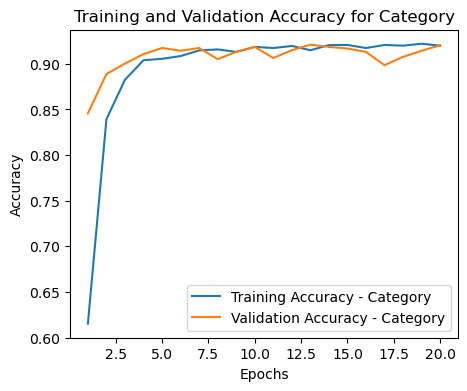

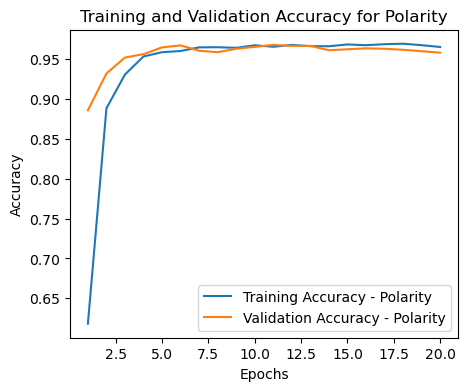

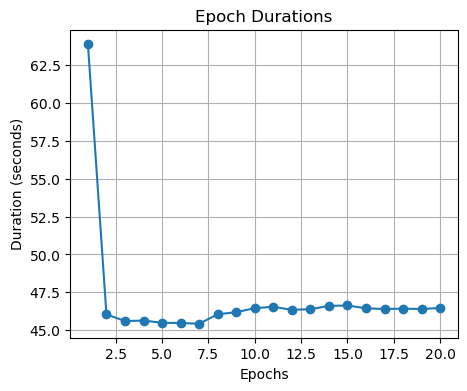

In [5]:
# -------------------------------
# 7. Visualization of Training History
# -------------------------------

def plot_history(history, epoch_durations):
    epochs_range = range(1, len(history['train_loss']) + 1)
    
    # Plot Total Loss
    plt.figure(figsize=(5, 4))
    plt.plot(epochs_range, history['train_loss'], label='Training Loss')
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Total Loss')
    plt.legend()
    plt.show()
    
    # Plot Category Loss
    plt.figure(figsize=(5, 4))
    plt.plot(epochs_range, history['train_cce_loss_category'], label='Training CCE Loss - Category')
    plt.plot(epochs_range, history['val_cce_loss_category'], label='Validation CCE Loss - Category')
    plt.xlabel('Epochs')
    plt.ylabel('CCE Loss')
    plt.title('Training and Validation CCE Loss for Category')
    plt.legend()
    plt.show()
    
    # Plot Polarity Loss
    plt.figure(figsize=(5, 4))
    plt.plot(epochs_range, history['train_cce_loss_polarity'], label='Training CCE Loss - Polarity')
    plt.plot(epochs_range, history['val_cce_loss_polarity'], label='Validation CCE Loss - Polarity')
    plt.xlabel('Epochs')
    plt.ylabel('CCE Loss')
    plt.title('Training and Validation CCE Loss for Polarity')
    plt.legend()
    plt.show()
    
    # Plot Smoothness Loss
    plt.figure(figsize=(5, 4))
    plt.plot(epochs_range, history['train_smoothness_loss'], label='Training Smoothness Loss')
    plt.plot(epochs_range, history['val_smoothness_loss'], label='Validation Smoothness Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Smoothness Loss')
    plt.title('Training and Validation Smoothness Loss')
    plt.legend()
    plt.show()
    
    # Plot Category Accuracy
    plt.figure(figsize=(5, 4))
    plt.plot(epochs_range, history['train_accuracy_category'], label='Training Accuracy - Category')
    plt.plot(epochs_range, history['val_accuracy_category'], label='Validation Accuracy - Category')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy for Category')
    plt.legend()
    plt.show()
    
    # Plot Polarity Accuracy
    plt.figure(figsize=(5, 4))
    plt.plot(epochs_range, history['train_accuracy_polarity'], label='Training Accuracy - Polarity')
    plt.plot(epochs_range, history['val_accuracy_polarity'], label='Validation Accuracy - Polarity')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy for Polarity')
    plt.legend()
    plt.show()
    
    # Plot Epoch Durations
    plt.figure(figsize=(5, 4))
    plt.plot(epochs_range, epoch_durations, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Duration (seconds)')
    plt.title('Epoch Durations')
    plt.grid(True)
    plt.show()

# Call the plotting function
plot_history(history, epoch_durations)


1/1 [==============================] - 0s 68ms/step
Test Accuracy (Category): 0.9204
Test Macro F1 Score (Category): 0.9149
Test Macro Precision (Category): 0.9193
Test Macro Recall (Category): 0.9138
Test Accuracy (Polarity): 0.9581
Test Macro F1 Score (Polarity): 0.9577
Test Macro Precision (Polarity): 0.9578
Test Macro Recall (Polarity): 0.9577


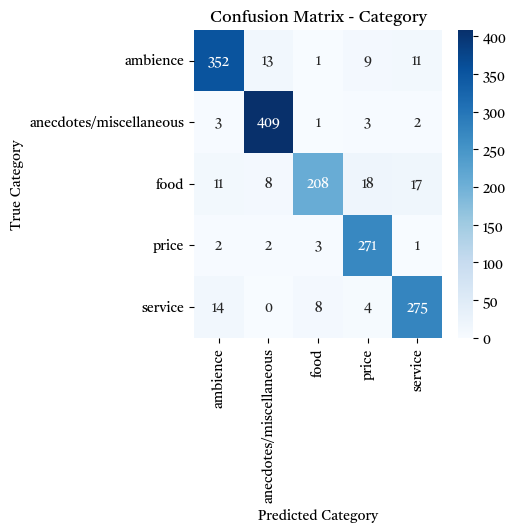

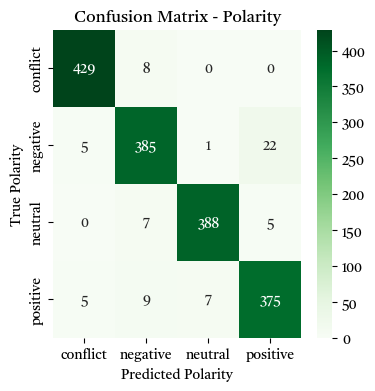

1/1 [==============================] - 0s 47ms/step


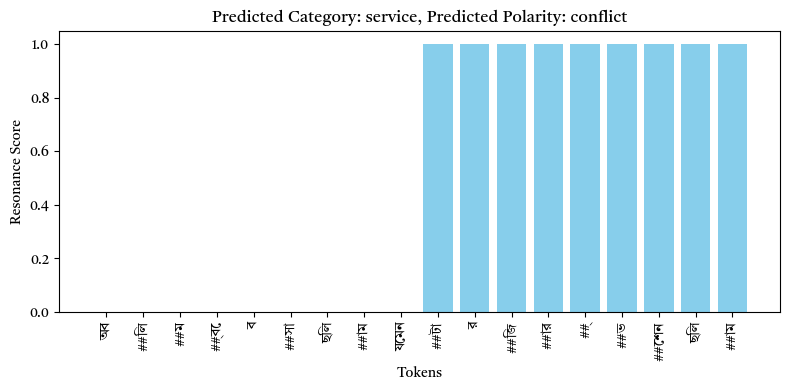

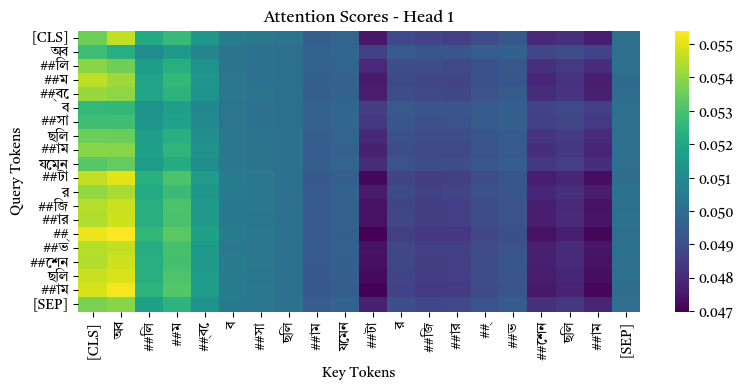

In [ ]:
# -------------------------------
# 6. Evaluation and Visualization
# -------------------------------

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.font_manager as fm  # Import font manager

# Define the font path
font_path = r'F:\Aspect Based Sentiment Analysis\Resturant\TiroBangla-Regular.ttf'

# Register the font
fm.fontManager.addfont(font_path)

# Create a FontProperties object
font_prop = fm.FontProperties(fname=font_path)

# Get the font name
font_name = font_prop.get_name()

# Set the custom font as the default font for all plots
plt.rcParams['font.family'] = font_name

def decode_tokens(input_ids, tokenizer):
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    return tokens

def visualize_resonance_scores(tokens, resonance_scores, predicted_label_category, predicted_label_polarity, label_encoder_category, label_encoder_polarity, attention_mask=None):
    """
    Plots resonance scores for each token in the sentence, excluding padding and special tokens.
    """
    # If attention_mask is provided, use it to filter tokens
    if attention_mask is not None:
        valid_indices = attention_mask > 0
        tokens = np.array(tokens)[valid_indices]
        resonance_scores = resonance_scores[valid_indices]
    
    # Exclude special tokens [CLS], [SEP], and [PAD] if present
    special_tokens = {'[CLS]', '[SEP]', '[PAD]'}
    mask = ~np.isin(tokens, list(special_tokens))
    tokens = tokens[mask]
    resonance_scores = resonance_scores[mask]
    
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(tokens)), resonance_scores, color='skyblue')
    plt.xticks(range(len(tokens)), tokens, rotation=90)  # Tokens will use the global font
    plt.title(f"Predicted Category: {label_encoder_category.inverse_transform([predicted_label_category])[0]}, Predicted Polarity: {label_encoder_polarity.inverse_transform([predicted_label_polarity])[0]}")
    plt.xlabel("Tokens")
    plt.ylabel("Resonance Score")
    plt.tight_layout()
    plt.show()

def visualize_attention_scores(tokens, attention_scores, head=0):
    """
    Plots attention scores for a specific head in the Multi-Head Attention layer.
    """
    # Select the desired head
    # attention_scores shape: (batch_size, num_heads, seq_length, seq_length)
    attention = attention_scores[0][head]  # Shape: (seq_length, seq_length)
    
    plt.figure(figsize=(8, 4))
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title(f'Attention Scores - Head {head+1}')
    plt.xlabel('Key Tokens')
    plt.ylabel('Query Tokens')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Predict on the test set
all_predictions_category = []
all_predictions_polarity = []
all_labels_category = []
all_labels_polarity = []
all_resonance_scores = []

for batch_inputs, batch_labels_category, batch_labels_polarity in test_dataset:
    input_ids = batch_inputs['input_ids']
    attention_masks = batch_inputs['attention_masks']
    adjacency = batch_inputs['adjacency']
    
    predictions_category, predictions_polarity, resonance_scores, attention_scores = model.predict([input_ids, attention_masks, adjacency])
    predicted_labels_category = np.argmax(predictions_category, axis=1)
    predicted_labels_polarity = np.argmax(predictions_polarity, axis=1)
    
    all_predictions_category.extend(predicted_labels_category)
    all_predictions_polarity.extend(predicted_labels_polarity)
    all_labels_category.extend(batch_labels_category.numpy())
    all_labels_polarity.extend(batch_labels_polarity.numpy())
    all_resonance_scores.extend(resonance_scores)

# Calculate metrics for Category
accuracy_category = accuracy_score(all_labels_category, all_predictions_category)
f1_category = f1_score(all_labels_category, all_predictions_category, average='macro')
precision_category = precision_score(all_labels_category, all_predictions_category, average='macro')
recall_category = recall_score(all_labels_category, all_predictions_category, average='macro')

print(f"Test Accuracy (Category): {accuracy_category:.4f}")
print(f"Test Macro F1 Score (Category): {f1_category:.4f}")
print(f"Test Macro Precision (Category): {precision_category:.4f}")
print(f"Test Macro Recall (Category): {recall_category:.4f}")

# Calculate metrics for Polarity
accuracy_polarity = accuracy_score(all_labels_polarity, all_predictions_polarity)
f1_polarity = f1_score(all_labels_polarity, all_predictions_polarity, average='macro')
precision_polarity = precision_score(all_labels_polarity, all_predictions_polarity, average='macro')
recall_polarity = recall_score(all_labels_polarity, all_predictions_polarity, average='macro')

print(f"Test Accuracy (Polarity): {accuracy_polarity:.4f}")
print(f"Test Macro F1 Score (Polarity): {f1_polarity:.4f}")
print(f"Test Macro Precision (Polarity): {precision_polarity:.4f}")
print(f"Test Macro Recall (Polarity): {recall_polarity:.4f}")

# Confusion Matrix for Category
conf_matrix_category = tf.math.confusion_matrix(all_labels_category, all_predictions_category).numpy()
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix_category, annot=True, fmt='d', cmap='Blues',
            xticklabels=category_encoder.classes_,
            yticklabels=category_encoder.classes_)
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.title('Confusion Matrix - Category')
plt.show()

# Confusion Matrix for Polarity
conf_matrix_polarity = tf.math.confusion_matrix(all_labels_polarity, all_predictions_polarity).numpy()
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix_polarity, annot=True, fmt='d', cmap='Greens',
            xticklabels=polarity_encoder.classes_,
            yticklabels=polarity_encoder.classes_)
plt.xlabel('Predicted Polarity')
plt.ylabel('True Polarity')
plt.title('Confusion Matrix - Polarity')
plt.show()

# Visualizing Resonance Scores for a Sample Sentence
def visualize_sample_resonance(input_ids, attention_mask, adjacency, label_encoder_category, label_encoder_polarity, sample_index=0):
    """
    Visualizes resonance scores and attention for a single sample.
    """
    sample_input_ids = input_ids[sample_index:sample_index+1]
    sample_attention_masks = attention_mask[sample_index:sample_index+1]
    sample_adjacency = adjacency[sample_index:sample_index+1]
    sample_label_category = y_test_category[sample_index]
    sample_label_polarity = y_test_polarity[sample_index]
    
    # Predict sentiment and get resonance scores
    predictions_category, predictions_polarity, resonance_scores, attention_scores = model.predict([sample_input_ids, sample_attention_masks, sample_adjacency])
    predicted_label_category = np.argmax(predictions_category, axis=1)[0]
    predicted_label_polarity = np.argmax(predictions_polarity, axis=1)[0]
    
    # Decode tokens
    tokens = decode_tokens(sample_input_ids[0], tokenizer)
    
    # Extract and normalize resonance scores
    resonance = resonance_scores[0].squeeze()[:len(tokens)]
    # Ensure resonance is float32 to match plotting
    resonance_normalized = (resonance - np.min(resonance)) / (np.max(resonance) - np.min(resonance) + 1e-8)
    resonance_normalized = resonance_normalized.astype(np.float32)
    
    # Extract attention mask for the sample
    attention_mask_sample = sample_attention_masks[0]
    
    # Visualize resonance scores
    visualize_resonance_scores(
        tokens=tokens,
        resonance_scores=resonance_normalized,
        predicted_label_category=predicted_label_category,
        predicted_label_polarity=predicted_label_polarity,
        label_encoder_category=category_encoder,
        label_encoder_polarity=polarity_encoder,
        attention_mask=attention_mask_sample  # Pass attention mask to exclude padding and special tokens
    )
    
    # Visualize attention scores for the first head
    visualize_attention_scores(tokens, attention_scores, head=0)

# Visualize a sample (e.g., first sample in the test set)
visualize_sample_resonance(X_test_ids, X_test_masks, adjacency_test, category_encoder, polarity_encoder, sample_index=15)


1/1 [==============================] - 0s 106ms/step


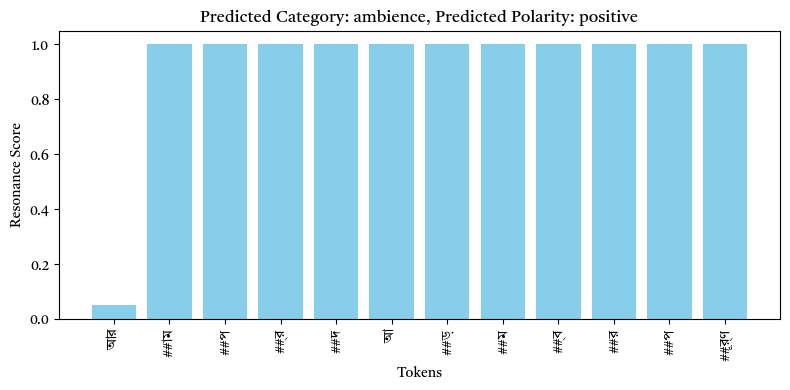

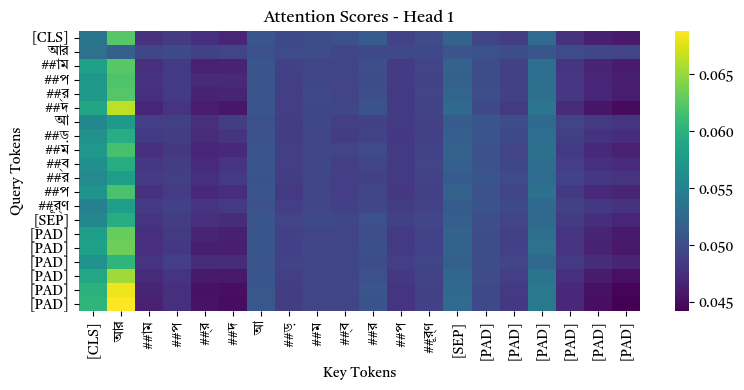

In [13]:
# Visualize a sample (e.g., first sample in the test set)
visualize_sample_resonance(X_test_ids, X_test_masks, adjacency_test, category_encoder, polarity_encoder, sample_index=105)

Enabled memory growth for 1 GPU(s).
Initial DataFrame:
                                                Text                 Category  \
0              স্টাফ কিন্তু, আমাদের জন্য ভয়ঙ্কর ছিল।                  service   
1  শুধুমাত্র,রিডামিং ফ্যাক্টর খাদ্য ছিল,পুরোপুরি ...                     food   
2  শুধুমাত্র,রিডামিং ফ্যাক্টর খাদ্য ছিল,পুরোপুরি ...  anecdotes/miscellaneous   
3  খাবার একদমই ব্যতিক্রমী, একটি খুব সক্ষম রান্নাঘ...                     food   
4  যেখানে গাব্রিয়েলা লোকালি আপনাকে শুভেচ্ছা জানা...                  service   

   Polarity  
0  negative  
1  positive  
2  negative  
3  positive  
4  positive  
Initial Data Shape: (2059, 3)
DataFrame after text cleaning:
                                                Text                 Category  \
0                                       স্টাফ ভয়ঙ্কর                  service   
1  শুধুমাত্ররিডামিং ফ্যাক্টর খাদ্য ছিলপুরোপুরি ন্...                     food   
2  শুধুমাত্ররিডামিং ফ্যাক্টর খাদ্য ছিলপুরোপুরি ন্...  anecdotes/miscel

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Tokenizing: 100%|██████████| 258/258 [00:02<00:00, 122.13it/s]


Training samples: 6582
Testing samples: 1646


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_1"
__________________________________________________________________________________________________


f:\Mini Conda\envs\env\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 20)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  177853440   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 20,                                                
                                768),                                                             
          

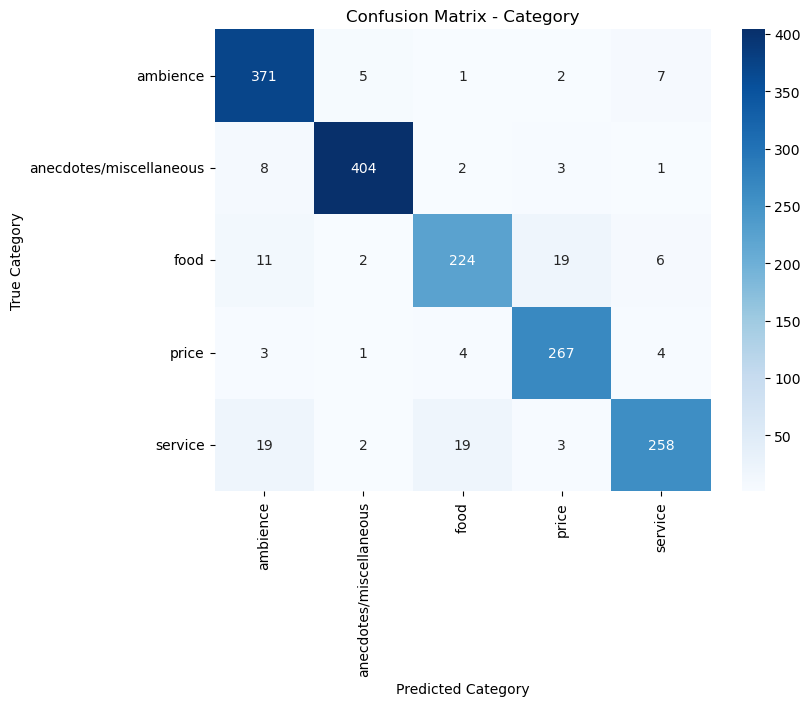

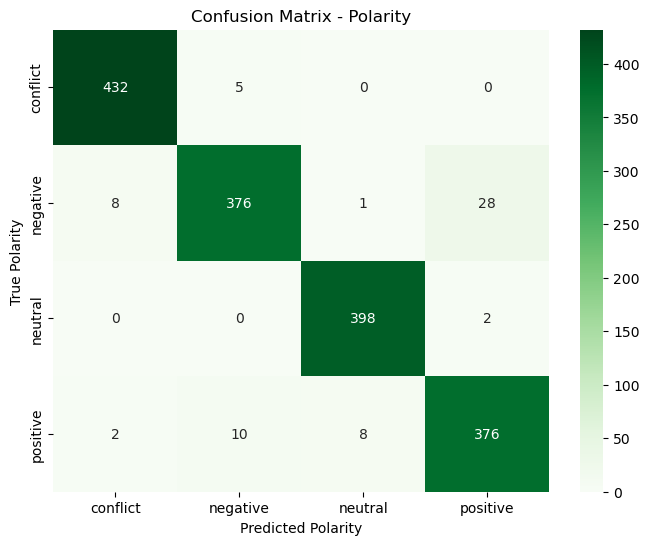

1/1 [==============================] - 0s 53ms/step


ValueError: too many values to unpack (expected 4)

In [ ]:
# sentiment_analysis_novel.py

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import random
import os
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils.class_weight import compute_class_weight
import re
import nltk
from nltk.corpus import stopwords
# Note: WordNetLemmatizer is for English; it's not used here.

# -------------------------------
# 0. Environment Setup
# -------------------------------

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

# Suppress TensorFlow warnings for cleaner output
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# -------------------------------
# 1. GPU Memory Management
# -------------------------------

# Enable memory growth to prevent TensorFlow from allocating all GPU memory at once
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Enabled memory growth for {len(gpus)} GPU(s).")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

# -------------------------------
# 2. Data Preparation
# -------------------------------

# Load the dataset
# Ensure the CSV has at least three columns: 'Text', 'Category', 'Polarity'
df = pd.read_csv(r"F:\Context-Resonance Transformer\Restaurant - Sheet1.csv")
df = df[['Text', 'Category', 'Polarity']]
print("Initial DataFrame:")
print(df.head())
print(f"Initial Data Shape: {df.shape}")

# Initialize Bengali stopwords
nltk.download('stopwords')

# Attempt to load Bengali stopwords; if not available, skip stopword removal
try:
    stop_words = set(stopwords.words('bengali'))
except LookupError:
    print("Bengali stopwords not found. Skipping stopword removal.")
    stop_words = set()

# Function to clean text
def clean_text(text):
    # Keep only Bengali characters: Unicode range for Bengali: \u0980 - \u09FF
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces

    words = text.split()
    # Remove stopwords if available
    if stop_words:
        words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['Text'] = df['Text'].apply(clean_text)
print("DataFrame after text cleaning:")
print(df.head())

# Upsampling 'Category' and 'Polarity' to balance classes
from sklearn.utils import resample

# Define a function to perform random upsampling
def upsample(df, target_column):
    # Get the maximum count of samples in any class
    max_count = df[target_column].value_counts().max()

    # Separate each class and upsample the minority classes
    upsampled_dfs = []
    for label in df[target_column].unique():
        df_label = df[df[target_column] == label]

        # Upsample minority classes to match the majority class count
        df_upsampled = resample(
            df_label,
            replace=True,    
            n_samples=max_count,     
            random_state=42  
        )
        upsampled_dfs.append(df_upsampled)

    # Combine the upsampled DataFrames
    return pd.concat(upsampled_dfs)

# Apply upsampling to 'Category' and 'Polarity'
df_upsampled_category = upsample(df, 'Category')
df_upsampled_polarity = upsample(df_upsampled_category, 'Polarity')

# Shuffle the DataFrame to mix the resampled classes
df_upsampled = df_upsampled_polarity.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class distribution
print("Category distribution after upsampling:")
print(df_upsampled['Category'].value_counts())
print("\nPolarity distribution after upsampling:")
print(df_upsampled['Polarity'].value_counts())

# Encode 'Category' and 'Polarity' labels
category_encoder = LabelEncoder()
polarity_encoder = LabelEncoder()

df_upsampled['Category_encoded'] = category_encoder.fit_transform(df_upsampled['Category'])
df_upsampled['Polarity_encoded'] = polarity_encoder.fit_transform(df_upsampled['Polarity'])

# Verify encoding
print("Encoded Category and Polarity:")
print(df_upsampled[['Category', 'Category_encoded', 'Polarity', 'Polarity_encoded']].head())


tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def window_based_adjacency(sentences, window_size=2, max_len=20):
    """
    Creates adjacency matrices based on a sliding window approach.
    Each token is connected to its neighbors within the window size.
    """
    adjacency_matrices = []

    for sentence in sentences:
        tokens = sentence.split()[:max_len]
        num_tokens = len(tokens)
        adj = np.zeros((max_len, max_len), dtype=np.float32)

        for i in range(num_tokens):
            for j in range(max(i - window_size, 0), min(i + window_size + 1, num_tokens)):
                if i != j:
                    adj[i, j] = 1.0

        adjacency_matrices.append(adj)

    return np.array(adjacency_matrices, dtype=np.float32)

def tokenize_sentences(sentences, tokenizer, max_len=20, batch_size=32):
    """
    Tokenizes sentences in batches for efficiency.
    """
    input_ids = []
    attention_masks = []

    for i in tqdm(range(0, len(sentences), batch_size), desc="Tokenizing"):
        batch = sentences[i:i+batch_size]
        encoded = tokenizer(
            list(batch),
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    # Concatenate all batches
    input_ids = tf.concat(input_ids, axis=0).numpy()
    attention_masks = tf.concat(attention_masks, axis=0).numpy()

    return input_ids, attention_masks

# Tokenize the data
input_ids, attention_masks = tokenize_sentences(df_upsampled['Text'].values, tokenizer, max_len=20, batch_size=32)

# Create window-based adjacency matrices
adjacency_matrices = window_based_adjacency(df_upsampled['Text'].values, window_size=2, max_len=20)

# Define labels for multi-task learning
labels_category = df_upsampled['Category_encoded'].values
labels_polarity = df_upsampled['Polarity_encoded'].values

# Split the data into training and testing sets
X_train_ids, X_test_ids, X_train_masks, X_test_masks, adjacency_train, adjacency_test, y_train_category, y_test_category, y_train_polarity, y_test_polarity = train_test_split(
    input_ids, attention_masks, adjacency_matrices, labels_category, labels_polarity, test_size=0.2, random_state=42, stratify=labels_category
)

print(f"Training samples: {X_train_ids.shape[0]}")
print(f"Testing samples: {X_test_ids.shape[0]}")

# -------------------------------
# 3. Model Architecture with GAT and Hierarchical Multi-Task Learning
# -------------------------------

from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from spektral.layers import GATConv 

# Updated GNNContextResonance with GAT layers
class GNNContextResonance(tf.keras.layers.Layer):
    def __init__(self, hidden_size, **kwargs):
        super(GNNContextResonance, self).__init__(**kwargs)
        self.gat1 = GATConv(128, activation='elu')  
        self.gat2 = GATConv(hidden_size, activation='elu')  
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid') 

    def call(self, inputs, adjacency):
        """
        inputs: BERT embeddings (batch_size, seq_length, hidden_size)
        adjacency: Adjacency matrices (batch_size, seq_length, seq_length)
        """
        # Apply GAT layers
        x = self.gat1([inputs, adjacency]) 
        x = self.gat2([x, adjacency])      

        # Compute resonance scores
        resonance_scores = self.dense(x) 
        resonance_scores = tf.nn.sigmoid(resonance_scores)  

        # Modulate inputs with resonance scores
        modulated_inputs = inputs * resonance_scores  

        return modulated_inputs, resonance_scores  

    def get_config(self):
        base_config = super(GNNContextResonance, self).get_config()
        return base_config

# Define the complete model with GNNContextResonance and hierarchical multi-task outputs
def build_model_with_gnn(bert_model, hidden_size, max_len=20):
    # Define Inputs
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='attention_masks')
    adjacency = Input(shape=(max_len, max_len), dtype=tf.float32, name='adjacency')

    # Get BERT embeddings
    bert_outputs = bert_model([input_ids, attention_masks])
    sequence_output = bert_outputs.last_hidden_state

    # Apply GNN-Based ContextResonance
    gnn_resonance_layer = GNNContextResonance(hidden_size)
    transformer_output, resonance_scores = gnn_resonance_layer(sequence_output, adjacency)

    # Continue with Transformer Block (Multi-Head Attention + FFN)
    attention_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=12, key_dim=hidden_size // 12, name='multi_head_attention'
    )
    attention_output, attention_scores = attention_layer(
        query=transformer_output,
        value=transformer_output,
        key=transformer_output,
        return_attention_scores=True
    )

    # Add & Normalize
    attention_output = LayerNormalization(epsilon=1e-6)(transformer_output + attention_output)

    # Feed-Forward Network
    ffn_output = Dense(3072, activation='relu')(attention_output)
    ffn_output = Dense(hidden_size)(ffn_output)

    # Add & Normalize
    ffn_output = LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)

    # Pooling: Take the mean of the token embeddings
    pooled_output = GlobalAveragePooling1D(name='global_average_pooling1d')(ffn_output)

    # Classification Heads for Hierarchical Multi-Task Learning
    dropout = Dropout(0.3)(pooled_output)

    # Category Output
    category_output = Dense(len(category_encoder.classes_), activation='softmax', name='category_output')(dropout)

    # Combine pooled output and category prediction for polarity prediction
    combined_input = Concatenate()([dropout, category_output])

    # Polarity Output uses combined input
    polarity_dropout = Dropout(0.3)(combined_input)
    polarity_output = Dense(len(polarity_encoder.classes_), activation='softmax', name='polarity_output')(polarity_dropout)

    # Include `pooled_output` in the outputs
    model = Model(
        inputs=[input_ids, attention_masks, adjacency],
        outputs=[category_output, polarity_output, resonance_scores, attention_scores, pooled_output]  
    )

    return model

# Load pre-trained multilingual BERT model
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')
hidden_size = bert_model.config.hidden_size  # Typically 768

# Build the model
model = build_model_with_gnn(bert_model, hidden_size, max_len=20)

# Summary of the model
model.summary()

# -------------------------------
# 4. Defining the Custom Loss Function, Contrastive Loss, and Metrics
# -------------------------------

# Define the optimizer
optimizer = Adam(learning_rate=2e-5, epsilon=1e-08)

# Define the standard loss functions with 'none' reduction to get per-sample losses
loss_fn_category = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
loss_fn_polarity = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

# Define metrics
train_accuracy_category = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy_category')
train_accuracy_polarity = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy_polarity')
val_accuracy_category = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy_category')
val_accuracy_polarity = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy_polarity')

# Compute class weights based on the training labels for both tasks
class_weights_category = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_category),
    y=y_train_category
)

class_weights_polarity = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_polarity),
    y=y_train_polarity
)

# Convert class_weights to dictionaries for easy lookup
class_weights_dict_category = {i: weight for i, weight in enumerate(class_weights_category)}
class_weights_dict_polarity = {i: weight for i, weight in enumerate(class_weights_polarity)}
print("Category Class Weights:", class_weights_dict_category)
print("Polarity Class Weights:", class_weights_dict_polarity)

# Define the supervised contrastive loss function
def supervised_contrastive_loss(labels, features, temperature=0.1):
    """
    Compute the supervised contrastive loss as in the paper:
    "Supervised Contrastive Learning" (https://arxiv.org/abs/2004.11362)
    """
    # Ensure labels are integers and features are normalized
    labels = tf.reshape(labels, [-1])
    label_mask = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    features = tf.math.l2_normalize(features, axis=1)
    similarity_matrix = tf.matmul(features, features, transpose_b=True) / temperature
    logits_max = tf.reduce_max(similarity_matrix, axis=1, keepdims=True)
    logits = similarity_matrix - logits_max
    exp_logits = tf.exp(logits) * tf.cast(label_mask, tf.float32)
    log_prob = logits - tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True) + 1e-8)
    mean_log_prob_pos = tf.reduce_sum(log_prob * tf.cast(label_mask, tf.float32), axis=1) / tf.reduce_sum(tf.cast(label_mask, tf.float32), axis=1)
    loss = -tf.reduce_mean(mean_log_prob_pos)
    return loss

@tf.function
def train_step(input_ids, attention_masks, adjacency, labels_category, labels_polarity):
    with tf.GradientTape() as tape:
        # Forward pass
        predictions_category, predictions_polarity, resonance_scores, _, features = model([input_ids, attention_masks, adjacency], training=True)

        # Compute per-sample standard loss for category
        cce_loss_category = loss_fn_category(labels_category, predictions_category)

        # Compute per-sample standard loss for polarity
        cce_loss_polarity = loss_fn_polarity(labels_polarity, predictions_polarity)

        # Convert class_weights_dict to tensors with dtype float32
        class_weights_tensor_category = tf.gather(tf.constant(class_weights_category, dtype=tf.float32), labels_category)
        class_weights_tensor_polarity = tf.gather(tf.constant(class_weights_polarity, dtype=tf.float32), labels_polarity)

        # Apply class weights to the per-sample loss for category
        weighted_cce_loss_category = cce_loss_category * class_weights_tensor_category  
        weighted_cce_loss_category_mean = tf.reduce_mean(weighted_cce_loss_category)

        # Apply class weights to the per-sample loss for polarity
        weighted_cce_loss_polarity = cce_loss_polarity * class_weights_tensor_polarity 
        weighted_cce_loss_polarity_mean = tf.reduce_mean(weighted_cce_loss_polarity)

        # Compute smoothness loss
        resonance_scores_squeezed = tf.squeeze(resonance_scores, axis=-1)  # (batch_size, seq_length)
        resonance_diff = resonance_scores_squeezed[:, :, tf.newaxis] - resonance_scores_squeezed[:, tf.newaxis, :] 
        squared_diff = tf.square(resonance_diff)
        smoothness_loss = tf.reduce_sum(adjacency * squared_diff, axis=[1,2])  # (batch_size,)
        smoothness_loss = tf.reduce_mean(smoothness_loss)

        # Compute contrastive loss on the pooled output
        contrastive_loss_value = supervised_contrastive_loss(labels_category, features)

        # Total loss with class weights
        alpha = 0.1  # Weight for smoothness loss
        beta = 0.1   # Weight for contrastive loss
        total_loss = (weighted_cce_loss_category_mean + weighted_cce_loss_polarity_mean
                      + alpha * smoothness_loss + beta * contrastive_loss_value)

    # Compute gradients
    gradients = tape.gradient(total_loss, model.trainable_variables)

    # Update weights
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Update metrics
    train_accuracy_category.update_state(labels_category, predictions_category)
    train_accuracy_polarity.update_state(labels_polarity, predictions_polarity)

    return total_loss, weighted_cce_loss_category_mean, weighted_cce_loss_polarity_mean, smoothness_loss, contrastive_loss_value

@tf.function
def test_step(input_ids, attention_masks, adjacency, labels_category, labels_polarity):
    # Forward pass
    predictions_category, predictions_polarity, resonance_scores, _, features = model([input_ids, attention_masks, adjacency], training=False)

    # Compute per-sample standard loss for category
    cce_loss_category = loss_fn_category(labels_category, predictions_category)

    # Compute per-sample standard loss for polarity
    cce_loss_polarity = loss_fn_polarity(labels_polarity, predictions_polarity)

    # Convert class_weights_dict to tensors with dtype float32
    class_weights_tensor_category = tf.gather(tf.constant(class_weights_category, dtype=tf.float32), labels_category)
    class_weights_tensor_polarity = tf.gather(tf.constant(class_weights_polarity, dtype=tf.float32), labels_polarity)

    # Apply class weights to the per-sample loss for category
    weighted_cce_loss_category = cce_loss_category * class_weights_tensor_category
    weighted_cce_loss_category_mean = tf.reduce_mean(weighted_cce_loss_category)

    # Apply class weights to the per-sample loss for polarity
    weighted_cce_loss_polarity = cce_loss_polarity * class_weights_tensor_polarity  
    weighted_cce_loss_polarity_mean = tf.reduce_mean(weighted_cce_loss_polarity)

    # Compute smoothness loss
    resonance_scores_squeezed = tf.squeeze(resonance_scores, axis=-1)  
    resonance_diff = resonance_scores_squeezed[:, :, tf.newaxis] - resonance_scores_squeezed[:, tf.newaxis, :] 
    squared_diff = tf.square(resonance_diff)
    smoothness_loss = tf.reduce_sum(adjacency * squared_diff, axis=[1,2])  
    smoothness_loss = tf.reduce_mean(smoothness_loss)

    # Compute contrastive loss on the pooled output
    contrastive_loss_value = supervised_contrastive_loss(labels_category, features)

    # Total loss with class weights
    alpha = 0.1 
    beta = 0.1  
    total_loss = (weighted_cce_loss_category_mean + weighted_cce_loss_polarity_mean
                  + alpha * smoothness_loss + beta * contrastive_loss_value)

    # Update metrics
    val_accuracy_category.update_state(labels_category, predictions_category)
    val_accuracy_polarity.update_state(labels_polarity, predictions_polarity)

    return total_loss, weighted_cce_loss_category_mean, weighted_cce_loss_polarity_mean, smoothness_loss, contrastive_loss_value

# -------------------------------
# 5. Training the Model
# -------------------------------

epochs = 10 
batch_size = 16
alpha = 0.1 
beta = 0.1 

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_train_ids,
        'attention_masks': X_train_masks,
        'adjacency': adjacency_train
    },
    y_train_category,
    y_train_polarity
)).shuffle(buffer_size=10000).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_test_ids,
        'attention_masks': X_test_masks,
        'adjacency': adjacency_test
    },
    y_test_category,
    y_test_polarity
)).batch(batch_size)

# Initialize history dictionaries
history = {
    'train_loss': [],
    'train_cce_loss_category': [],
    'train_cce_loss_polarity': [],
    'train_smoothness_loss': [],
    'train_contrastive_loss': [],
    'train_accuracy_category': [],
    'train_accuracy_polarity': [],
    'val_loss': [],
    'val_cce_loss_category': [],
    'val_cce_loss_polarity': [],
    'val_smoothness_loss': [],
    'val_contrastive_loss': [],
    'val_accuracy_category': [],
    'val_accuracy_polarity': []
}

# Training Loop
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch+1}")

    # Reset metrics at the start of each epoch
    train_accuracy_category.reset_states()
    train_accuracy_polarity.reset_states()
    val_accuracy_category.reset_states()
    val_accuracy_polarity.reset_states()

    # Training
    total_loss_avg = tf.keras.metrics.Mean()
    cce_loss_category_avg = tf.keras.metrics.Mean()
    cce_loss_polarity_avg = tf.keras.metrics.Mean()
    smoothness_loss_avg = tf.keras.metrics.Mean()
    contrastive_loss_avg = tf.keras.metrics.Mean()

    for step, (batch_inputs, batch_labels_category, batch_labels_polarity) in enumerate(train_dataset):
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        adjacency = batch_inputs['adjacency']
        labels_category = batch_labels_category
        labels_polarity = batch_labels_polarity

        total_loss, cce_loss_cat, cce_loss_pol, smoothness_loss, contrastive_loss_value = train_step(
            input_ids, attention_masks, adjacency, labels_category, labels_polarity)

        total_loss_avg.update_state(total_loss)
        cce_loss_category_avg.update_state(cce_loss_cat)
        cce_loss_polarity_avg.update_state(cce_loss_pol)
        smoothness_loss_avg.update_state(smoothness_loss)
        contrastive_loss_avg.update_state(contrastive_loss_value)

        if step % 100 == 0:
            print(f"Step {step}: Total Loss = {total_loss_avg.result():.4f}, CCE Loss Category = {cce_loss_category_avg.result():.4f}, CCE Loss Polarity = {cce_loss_polarity_avg.result():.4f}, Smoothness Loss = {smoothness_loss_avg.result():.4f}, Contrastive Loss = {contrastive_loss_avg.result():.4f}, Train Accuracy Category = {train_accuracy_category.result():.4f}, Train Accuracy Polarity = {train_accuracy_polarity.result():.4f}")

    # Record training metrics
    history['train_loss'].append(total_loss_avg.result().numpy())
    history['train_cce_loss_category'].append(cce_loss_category_avg.result().numpy())
    history['train_cce_loss_polarity'].append(cce_loss_polarity_avg.result().numpy())
    history['train_smoothness_loss'].append(smoothness_loss_avg.result().numpy())
    history['train_contrastive_loss'].append(contrastive_loss_avg.result().numpy())
    history['train_accuracy_category'].append(train_accuracy_category.result().numpy())
    history['train_accuracy_polarity'].append(train_accuracy_polarity.result().numpy())

    print(f"Epoch {epoch+1} Training Loss: {total_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training CCE Loss Category: {cce_loss_category_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training CCE Loss Polarity: {cce_loss_polarity_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training Smoothness Loss: {smoothness_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training Contrastive Loss: {contrastive_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training Accuracy Category: {train_accuracy_category.result():.4f}")
    print(f"Epoch {epoch+1} Training Accuracy Polarity: {train_accuracy_polarity.result():.4f}")

    # Validation
    val_loss_avg = tf.keras.metrics.Mean()
    val_cce_loss_category_avg = tf.keras.metrics.Mean()
    val_cce_loss_polarity_avg = tf.keras.metrics.Mean()
    val_smoothness_loss_avg = tf.keras.metrics.Mean()
    val_contrastive_loss_avg = tf.keras.metrics.Mean()

    for batch_inputs, batch_labels_category, batch_labels_polarity in test_dataset:
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        adjacency = batch_inputs['adjacency']
        labels_category = batch_labels_category
        labels_polarity = batch_labels_polarity

        total_loss, cce_loss_cat, cce_loss_pol, smoothness_loss, contrastive_loss_value = test_step(
            input_ids, attention_masks, adjacency, labels_category, labels_polarity)

        val_loss_avg.update_state(total_loss)
        val_cce_loss_category_avg.update_state(cce_loss_cat)
        val_cce_loss_polarity_avg.update_state(cce_loss_pol)
        val_smoothness_loss_avg.update_state(smoothness_loss)
        val_contrastive_loss_avg.update_state(contrastive_loss_value)

    # Record validation metrics
    history['val_loss'].append(val_loss_avg.result().numpy())
    history['val_cce_loss_category'].append(val_cce_loss_category_avg.result().numpy())
    history['val_cce_loss_polarity'].append(val_cce_loss_polarity_avg.result().numpy())
    history['val_smoothness_loss'].append(val_smoothness_loss_avg.result().numpy())
    history['val_contrastive_loss'].append(val_contrastive_loss_avg.result().numpy())
    history['val_accuracy_category'].append(val_accuracy_category.result().numpy())
    history['val_accuracy_polarity'].append(val_accuracy_polarity.result().numpy())

    print(f"Epoch {epoch+1} Validation Loss: {val_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation CCE Loss Category: {val_cce_loss_category_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation CCE Loss Polarity: {val_cce_loss_polarity_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation Smoothness Loss: {val_smoothness_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation Contrastive Loss: {val_contrastive_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation Accuracy Category: {val_accuracy_category.result():.4f}")
    print(f"Epoch {epoch+1} Validation Accuracy Polarity: {val_accuracy_polarity.result():.4f}")

# -------------------------------
# 6. Evaluation and Visualization
# -------------------------------

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def decode_tokens(input_ids, tokenizer):
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    return tokens

def visualize_resonance_scores(tokens, resonance_scores, predicted_label_category, predicted_label_polarity, label_encoder_category, label_encoder_polarity, attention_mask=None):
    """
    Plots resonance scores for each token in the sentence, excluding padding and special tokens.
    """
    # If attention_mask is provided, use it to filter tokens
    if attention_mask is not None:
        valid_indices = attention_mask > 0
        tokens = np.array(tokens)[valid_indices]
        resonance_scores = resonance_scores[valid_indices]

    # Exclude special tokens [CLS], [SEP], and [PAD] if present
    special_tokens = {'[CLS]', '[SEP]', '[PAD]'}
    mask = ~np.isin(tokens, list(special_tokens))
    tokens = tokens[mask]
    resonance_scores = resonance_scores[mask]

    plt.figure(figsize=(12, 4))
    plt.bar(range(len(tokens)), resonance_scores, color='skyblue')
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.title(f"Predicted Category: {label_encoder_category.inverse_transform([predicted_label_category])[0]}, Predicted Polarity: {label_encoder_polarity.inverse_transform([predicted_label_polarity])[0]}")
    plt.xlabel("Tokens")
    plt.ylabel("Resonance Score")
    plt.tight_layout()
    plt.show()

def visualize_attention_scores(tokens, attention_scores, head=0):
    """
    Plots attention scores for a specific head in the Multi-Head Attention layer.
    """
    attention = attention_scores[0][head]  

    plt.figure(figsize=(10, 8))
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title(f'Attention Scores - Head {head+1}')
    plt.xlabel('Key Tokens')
    plt.ylabel('Query Tokens')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Predict on the test set
all_predictions_category = []
all_predictions_polarity = []
all_labels_category = []
all_labels_polarity = []
all_resonance_scores = []

for batch_inputs, batch_labels_category, batch_labels_polarity in test_dataset:
    input_ids = batch_inputs['input_ids']
    attention_masks = batch_inputs['attention_masks']
    adjacency = batch_inputs['adjacency']

    predictions_category, predictions_polarity, resonance_scores, attention_scores, _ = model.predict([input_ids, attention_masks, adjacency])
    predicted_labels_category = np.argmax(predictions_category, axis=1)
    predicted_labels_polarity = np.argmax(predictions_polarity, axis=1)

    all_predictions_category.extend(predicted_labels_category)
    all_predictions_polarity.extend(predicted_labels_polarity)
    all_labels_category.extend(batch_labels_category.numpy())
    all_labels_polarity.extend(batch_labels_polarity.numpy())
    all_resonance_scores.extend(resonance_scores)

# Calculate metrics for Category
accuracy_category = accuracy_score(all_labels_category, all_predictions_category)
f1_category = f1_score(all_labels_category, all_predictions_category, average='macro')
precision_category = precision_score(all_labels_category, all_predictions_category, average='macro')
recall_category = recall_score(all_labels_category, all_predictions_category, average='macro')

print(f"Test Accuracy (Category): {accuracy_category:.4f}")
print(f"Test Macro F1 Score (Category): {f1_category:.4f}")
print(f"Test Macro Precision (Category): {precision_category:.4f}")
print(f"Test Macro Recall (Category): {recall_category:.4f}")

# Calculate metrics for Polarity
accuracy_polarity = accuracy_score(all_labels_polarity, all_predictions_polarity)
f1_polarity = f1_score(all_labels_polarity, all_predictions_polarity, average='macro')
precision_polarity = precision_score(all_labels_polarity, all_predictions_polarity, average='macro')
recall_polarity = recall_score(all_labels_polarity, all_predictions_polarity, average='macro')

print(f"Test Accuracy (Polarity): {accuracy_polarity:.4f}")
print(f"Test Macro F1 Score (Polarity): {f1_polarity:.4f}")
print(f"Test Macro Precision (Polarity): {precision_polarity:.4f}")
print(f"Test Macro Recall (Polarity): {recall_polarity:.4f}")


# Confusion Matrix for Category
conf_matrix_category = tf.math.confusion_matrix(all_labels_category, all_predictions_category).numpy()
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_category, annot=True, fmt='d', cmap='Blues',
            xticklabels=category_encoder.classes_,
            yticklabels=category_encoder.classes_)
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.title('Confusion Matrix - Category')
plt.show()

# Confusion Matrix for Polarity
conf_matrix_polarity = tf.math.confusion_matrix(all_labels_polarity, all_predictions_polarity).numpy()
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_polarity, annot=True, fmt='d', cmap='Greens',
            xticklabels=polarity_encoder.classes_,
            yticklabels=polarity_encoder.classes_)
plt.xlabel('Predicted Polarity')
plt.ylabel('True Polarity')
plt.title('Confusion Matrix - Polarity')
plt.show()
def visualize_sample_resonance(input_ids, attention_mask, adjacency, label_encoder_category, label_encoder_polarity, sample_index=0):
    """
    Visualizes resonance scores and attention for a single sample.
    """
    sample_input_ids = input_ids[sample_index:sample_index+1]
    sample_attention_masks = attention_mask[sample_index:sample_index+1]
    sample_adjacency = adjacency[sample_index:sample_index+1]
    sample_label_category = y_test_category[sample_index]
    sample_label_polarity = y_test_polarity[sample_index]

    # Predict sentiment and get resonance scores
    predictions = model.predict([sample_input_ids, sample_attention_masks, sample_adjacency])
    predictions_category = predictions[0]
    predictions_polarity = predictions[1]
    resonance_scores = predictions[2]
    attention_scores = predictions[3]
    # pooled_output = predictions[4]  # If needed

    predicted_label_category = np.argmax(predictions_category, axis=1)[0]
    predicted_label_polarity = np.argmax(predictions_polarity, axis=1)[0]

    # Decode tokens
    tokens = decode_tokens(sample_input_ids[0], tokenizer)

    # Extract and normalize resonance scores
    resonance = resonance_scores[0].squeeze()[:len(tokens)]
    # Ensure resonance is float32 to match plotting
    resonance_normalized = (resonance - np.min(resonance)) / (np.max(resonance) - np.min(resonance) + 1e-8)
    resonance_normalized = resonance_normalized.astype(np.float32)

    # Extract attention mask for the sample
    attention_mask_sample = sample_attention_masks[0]

    # Visualize resonance scores
    visualize_resonance_scores(
        tokens=tokens,
        resonance_scores=resonance_normalized,
        predicted_label_category=predicted_label_category,
        predicted_label_polarity=predicted_label_polarity,
        label_encoder_category=category_encoder,
        label_encoder_polarity=polarity_encoder,
        attention_mask=attention_mask_sample  # Pass attention mask to exclude padding and special tokens
    )

    # Visualize attention scores for all heads
    visualize_all_attention_heads(tokens, attention_scores)
